Вы получили основные навыки обработки данных, теперь пора испытать их на практике. Сейчас вам предстоит заняться задачей классификации.

Представлен датасет центра приюта животных, и вашей задачей будет обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”).

Здесь вы вольны делать что угодно. Я хочу видеть от вас:
1. Проверка наличия/обработка пропусков
2. Проверьте взаимосвязи между признаками
3. Попробуйте создать свои признаки
4. Удалите лишние
5. Обратите внимание на текстовые столбцы. Подумайте, что можно извлечь полезного оттуда
6. Использование профайлера вам поможет.
7. Не забывайте, что у вас есть PCA (Метод главных компонент). Он может пригодиться.

Вспомните о всем, что я говорил на предыдущих занятиях. Не все будет пригодится, но в жизни вам никто не будет говорить, что использовать :)

Хорошим классификатором для этой задачи будет "Случайный лес" (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Понимать суть работы "леса" не обязательно на данном этапе, но качество предсказаний будет выше, чем с линейным классификатором. (если желаете, вот гайд https://adataanalyst.com/scikit-learn/linear-classification-method/)

Желаю успеха :)

In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr


%matplotlib inline

In [2]:
data = pd.read_csv('aac_shelter_outcomes.csv') 
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [3]:
data.shape

(78256, 12)

Нам необходимо предсказать 2 варианта Adoption и Transfer/
Фильтруем датасет.

In [4]:
data = data[(data['outcome_type'] == 'Adoption') | (data['outcome_type'] == 'Transfer')   ]     
data.shape

(56611, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56611 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    56609 non-null object
animal_id           56611 non-null object
animal_type         56611 non-null object
breed               56611 non-null object
color               56611 non-null object
date_of_birth       56611 non-null object
datetime            56611 non-null object
monthyear           56611 non-null object
name                38660 non-null object
outcome_subtype     29425 non-null object
outcome_type        56611 non-null object
sex_upon_outcome    56611 non-null object
dtypes: object(12)
memory usage: 5.6+ MB


# Включение переменных в модель

'age_upon_outcome',  - удалить, сделать группировку по возрасту

'animal_id',  - удалить

'animal_type', - важная переменная, оставить

'breed',  - порода - оставитn/ После детального анализа и построения модели - решила убрать показатель. Сгруппировать не получилось.

'color', - оставить/ После детального анализа и построения модели - решила убрать показатель. Сгруппировать не получилось.

'date_of_birth', - удалить, посчитать возраст и сгруппировать его

'datetime',  - проверить есть ли сезонность прогнозируемой переменной, если еть - оставить месяц

'monthyear',  - проверить - дублирует ли 'datetime', если да - удалить

'name',   - удалить

'outcome_subtype', - удалить, уточняет нашу прогнозируемую переменную, но не определяет ее.

'outcome_type', - прогнозируемая переменная

'sex_upon_outcome' - оставить

Проверим, дублируются ли 'datetime' и 'monthyear'

In [6]:
data['monthyear'] = pd.to_datetime(data['monthyear'])
data['datetime'] = pd.to_datetime(data['datetime'])

data['time'] = data['datetime'] - data['monthyear']
data['time'].sum()

Timedelta('0 days 00:00:00')

Переменные дублирются, оставляем 

Проверим, есть ли сезонность в работе приюта.
Создадим новую переменную - месяц принятия животного.

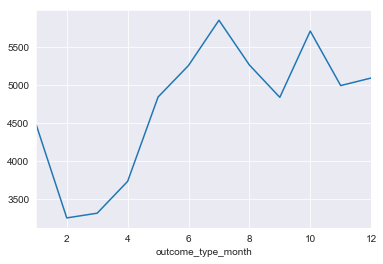

In [7]:
data['outcome_type_month'] = data['datetime'].dt.month

#data.outcome_type_month.value_counts()

data_dynamics = data.groupby('outcome_type_month')['outcome_type_month'].count()
data_dynamics.plot()

Сезонность есть, оставляем переменную 'outcome_type_month'.
'datetime' - исключем из анализа.

Создадим переменную с возрастом.

In [8]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'])
data['datetime'] = pd.to_datetime(data['datetime'])

data['age'] = data['datetime'] - data['date_of_birth']

data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,time,outcome_type_month,age
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male,0 days,7,15 days 16:04:00
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female,0 days,11,366 days 11:47:00
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male,0 days,6,429 days 14:20:00
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male,0 days,6,3300 days 15:50:00
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03,2013-10-07 13:06:00,2013-10-07 13:06:00,*Edgar,Partner,Transfer,Intact Male,0 days,10,126 days 13:06:00


Для уменьшения размерности сгруппируем возраст: менее 6 месяцев, более 6 месяцев.

In [9]:
data.loc[data['age'] <= '180 days', 'age type'] = 'small'
data.loc[data['age'] > '180 days', 'age type'] = 'old'

In [10]:
data = data.filter(items=['outcome_type', 'animal_type',
                          'outcome_type_month', 'sex_upon_outcome', 'age type'])
data.head()

,outcome_type,animal_type,outcome_type_month,sex_upon_outcome,age type
0,Transfer,Cat,7,Intact Male,small
1,Transfer,Dog,11,Spayed Female,old
2,Adoption,Dog,6,Neutered Male,old
3,Transfer,Dog,6,Neutered Male,old
5,Transfer,Dog,10,Intact Male,small


Проанализируем датасет после удаления и добавления новых показателей.

Поскольку количество пропущенных значений достаточно мало - удалим данные наблюдения.

In [12]:
import pandas_profiling

In [13]:
data.profile_report()

Посторим модель Случайных лесов.

Переведем все переменные в категориальный тип данных

In [14]:
for col in data:
    data[col] = data[col].astype('category')    

Применим One hot encoding, используя get_dummies

In [15]:
data_ohe = pd.get_dummies(data)

In [16]:
output_y = data_ohe.iloc[:,:2]
input_x = data_ohe.iloc[:,2:]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x, output_y, test_size=0.2)

In [18]:
from sklearn.utils import resample

N = pd.concat([X_train, y_train], axis=1)

Adoption_ = N[N.outcome_type_Adoption ==1]
Transfer_ = N[N.outcome_type_Adoption ==0]

print(len(Adoption_), len(Transfer_))

26402 18886


Сбалансируем выборки путем уменьшения наблюдений Adoption_.

In [19]:
Adoption_downsampled = resample(Adoption_,
                                replace = False, 
                                n_samples = len(Transfer_),
                                random_state = 1) 

N_downsampled = pd.concat([Adoption_downsampled, Transfer_])

y_train = N_downsampled[['outcome_type_Adoption', 'outcome_type_Transfer']]
X_train = N_downsampled.drop(['outcome_type_Adoption', 'outcome_type_Transfer'], axis=1)


In [20]:
from sklearn.ensemble import RandomForestClassifier

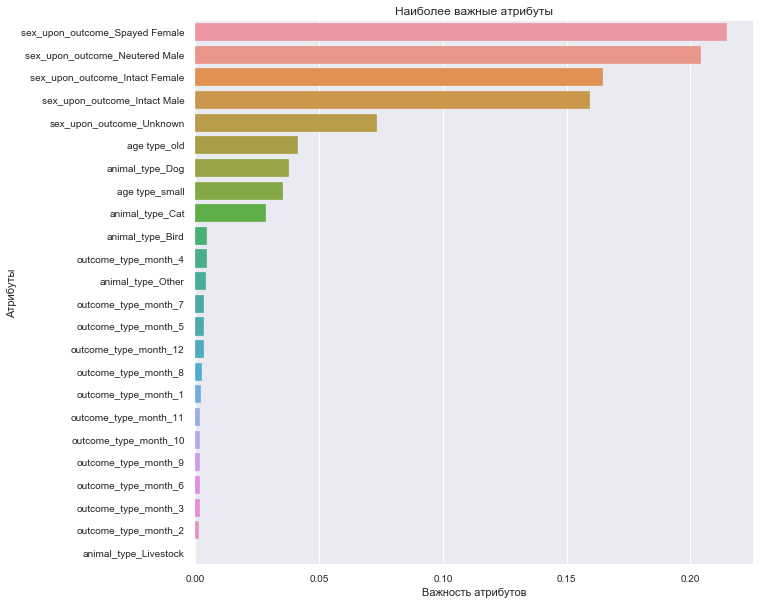

In [21]:
# создаем модель 
model = RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)

headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [22]:
model.score(X_test, y_test)

0.8085313079572551